In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import (accuracy_score, precision_score, classification_report,
                             recall_score, f1_score, make_scorer, confusion_matrix)

In [2]:
from pattern_clf import *
from datasets import *

# Estimation

In [3]:
def hmetric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 2 * tp * tn / (2*tp*tn + tp*fp + tn * fn)

In [7]:
param_grid = {
    "use_positive": [True, False],
    "alpha": [0.02, 0.05, 0.1, 0.5],
    "beta": [-0.2, -0.1, 0, 0.1, 0.2]
}
grid = GridSearchCV(LazyPatternClassifier(), param_grid,
                    scoring={'f1': 'f1',
                             'accuracy': 'accuracy',
                             'precision': 'precision',
                             'recall': 'recall',
                             'hmetric': make_scorer(hmetric)},
                    cv=KFold(n_splits=3, shuffle=True, random_state=495),
                    verbose=4, return_train_score=True,
                    n_jobs=1, refit=False)

In [5]:
loaders = [
    #('Breast Cancer', get_breast_cancer),
    ('Heart Disease', get_heart_disease),
    #('Mammographic Mass', get_mammographic_mass),
    #('Seismic Bumps', get_seismic_bumps),
    #('Titanic', get_titanic),
    #('Breast GSE', get_breast_GSE),
    #('Liver GSE', get_liver_GSE),
    #('Prostate GSE', get_prostate_GSE),
]

In [9]:
result = {}
for name, loader in loaders:
    X, y = loader()
    grid.fit(X, y)
    result[name] = grid.cv_results_.copy()
    print('Completed:', name)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=0 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=0, total=   8.8s
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=0 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=0, total=   8.6s
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=0 ......
[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=0, total=   9.1s
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=1 ......
[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=1, total=   9.7s
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=1 ......
[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=1, total=   9.9s
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=1 ......
[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=1, total=  10.0s
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=3 ......
[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=3, total=   9.0s
[CV] tolerance=1e-08, weight_classifiers=False, weights_iters=3 ......
[CV]  tolerance=1e-08, weight_classifiers=False, weights_iters=3, total=   9.7s
[CV] tolerance

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.6min finished


In [7]:
with open('results.pkl', 'wb') as f:
    pickle.dump(result, f)
!chmod -w 'results.pkl'

# Evaluation

In [8]:
with open('results.pkl', 'rb') as f:
    result = pickle.load(f)

In [10]:
frames = {key: pd.DataFrame(value) for key, value in result.items()}
for key, value in frames.items():
    value['dataset'] = key
metaframe = pd.concat(frames.values(), sort=True).reset_index(drop=True)

In [11]:
!rm -f metaframe.csv
metaframe.to_csv('metaframe.csv', index=False)
!chmod -w metaframe.csv
metaframe = pd.read_csv('metaframe.csv')
metaframe.sample(5)

,dataset,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1,mean_test_hmetric,mean_test_precision,mean_test_recall,mean_train_accuracy,mean_train_f1,...,std_test_accuracy,std_test_f1,std_test_hmetric,std_test_precision,std_test_recall,std_train_accuracy,std_train_f1,std_train_hmetric,std_train_precision,std_train_recall
4,Mammographic Mass,0.028506,5.370928,0.689156,0.728366,0.653627,0.632418,0.858686,0.932525,0.925339,...,0.017694,0.013831,0.026185,0.009921,0.020598,0.006014,0.006495,0.006495,0.0,0.011242
8,Titanic,0.024651,3.882397,0.515152,0.595727,0.401246,0.438760,0.934056,0.979237,0.972239,...,0.028964,0.031084,0.025645,0.037002,0.023882,0.001587,0.001125,0.001125,0.0,0.002131
7,Seismic Bumps,0.023061,0.315937,0.934210,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.001482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
0,Breast Cancer,0.031761,0.113475,0.372598,0.542753,0.000000,0.372598,1.000000,1.000000,1.000000,...,0.014181,0.015162,0.000000,0.014181,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,Heart Disease,0.018155,0.065154,0.544554,0.704878,0.000000,0.544554,1.000000,1.000000,1.000000,...,0.021389,0.018084,0.000000,0.021389,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [12]:
params = [
    'param_use_positive',
    #'param_alpha',
    #'param_beta',
]

metrics = [
    f'mean_{data}_{metric}'
    for data in ['test', 'train']
    for metric in ['f1', 'accuracy', 'precision', 'recall', 'hmetric']
]

foi = params + metrics + ['mean_fit_time', 'mean_score_time', 'dataset']

In [13]:
df = metaframe[foi].copy()
for param in params:
    df = df.set_index(param, drop=True, append=(param is not params[0]))

In [24]:
target = 'mean_test_hmetric'
df2 = df[[target, 'dataset']]

df3 = df2.iloc[:df2.shape[0] // df2.dataset.nunique()].copy()
df3.drop(columns=df3.columns, inplace=True)
for dataset in df2.dataset.unique():
    df3[dataset] = df2[target].values[(df2.dataset == dataset).values]

df3 = df3.sort_index().round(4)

In [25]:
datasets = ['Breast Cancer', 'Heart Disease', 'Mammographic Mass', 'Seismic Bumps',
        'Titanic', 'Breast GSE', 'Liver GSE', 'Prostate GSE']
for d in datasets:
    if d not in df3:
        df3[d] = np.nan
df3 = df3[datasets]
df3

,Breast Cancer,Heart Disease,Mammographic Mass,Seismic Bumps,Titanic,Breast GSE,Liver GSE,Prostate GSE
param_use_positive,,,,,,,,
False,0.0,0.0,0.6167,0.000,0.1759,NaN,NaN,NaN
True,0.0,0.0,0.6536,0.018,0.4012,NaN,NaN,NaN


In [26]:
print(df3.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Breast Cancer &  Heart Disease &  Mammographic Mass &  Seismic Bumps &  Titanic &  Breast GSE &  Liver GSE &  Prostate GSE \\
param\_use\_positive &                &                &                    &                &          &             &            &               \\
\midrule
False              &            0.0 &            0.0 &             0.6167 &          0.000 &   0.1759 &         NaN &        NaN &           NaN \\
True               &            0.0 &            0.0 &             0.6536 &          0.018 &   0.4012 &         NaN &        NaN &           NaN \\
\bottomrule
\end{tabular}



# Plots

In [3]:
data = {
    "Метод ближайшего\nсоседа": {'path':'./results/model_kNN', 'n_params': 2},
    "Логистическая\nрегрессия": {'path':'./results/model_LR', 'n_params': 2},
    "Случайный лес": {'path':'./results/model_RF', 'n_params': 2},
    "Алгоритм ленивой\nклассификации": {'path':'./results/A1', 'n_params': 1},
    "Алгоритм 1": {'path':'./results/A2', 'n_params': 3},
    "Алгоритм 2": {'path':'./results/A3', 'n_params': 3},
    "Алгоритм 3": {'path':'./results/A4', 'n_params': 3},
}

In [4]:
labels = list(data.keys())

In [5]:
datasets = ['Breast Cancer', 'Heart Disease', 'Mammographic Mass', 'Seismic Bumps',
        'Titanic',]

In [6]:
frames = {
    name: pd.read_csv(
        os.path.join(data_['path'], 'h_value.csv'),
        index_col=list(range(data_['n_params'])),
    )
    for name, data_ in data.items()
}

In [7]:
def get_h_values(series):
    if isinstance(series.index, pd.MultiIndex) and series.index.names[0] == 'param_use_positive':
        mask = series.index.codes[0].values().astype(bool)
        return series[mask].max(), series[~mask].max()
    else:
        return (series.max(), 0)

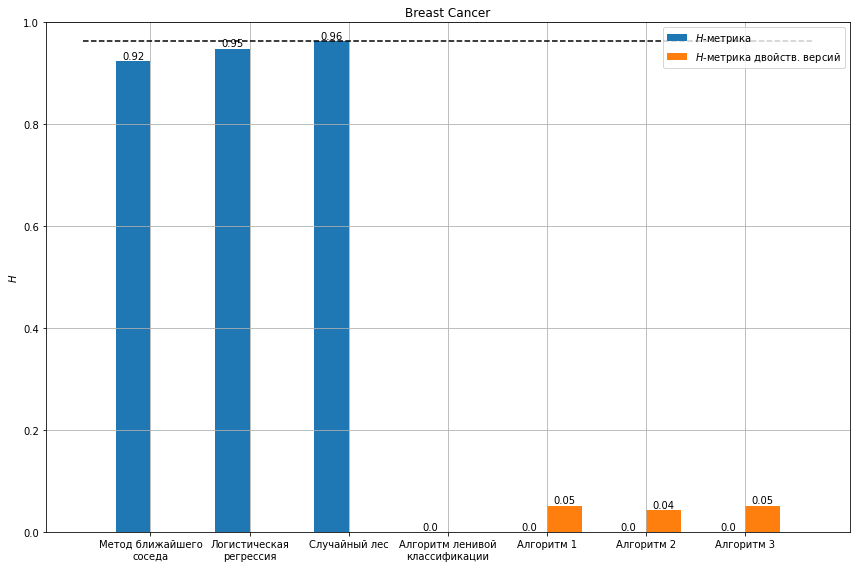

<Figure size 432x288 with 0 Axes>

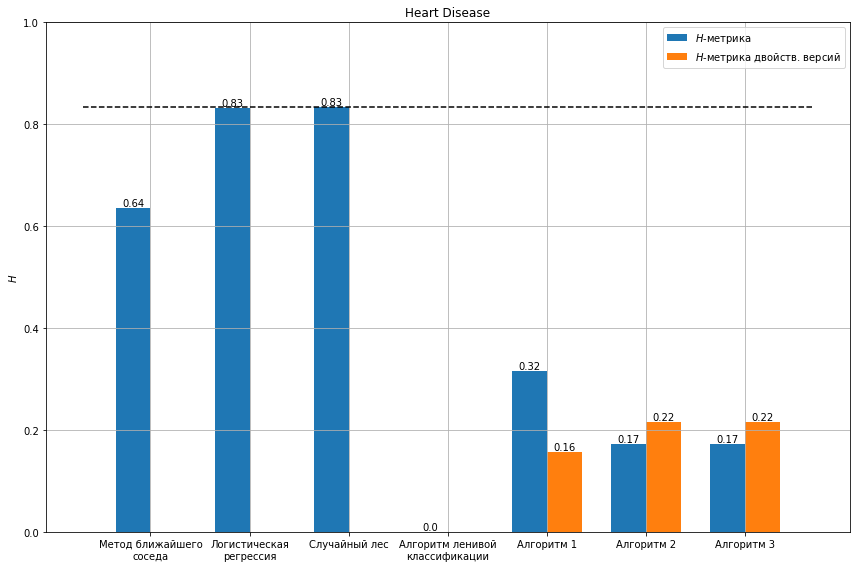

<Figure size 432x288 with 0 Axes>

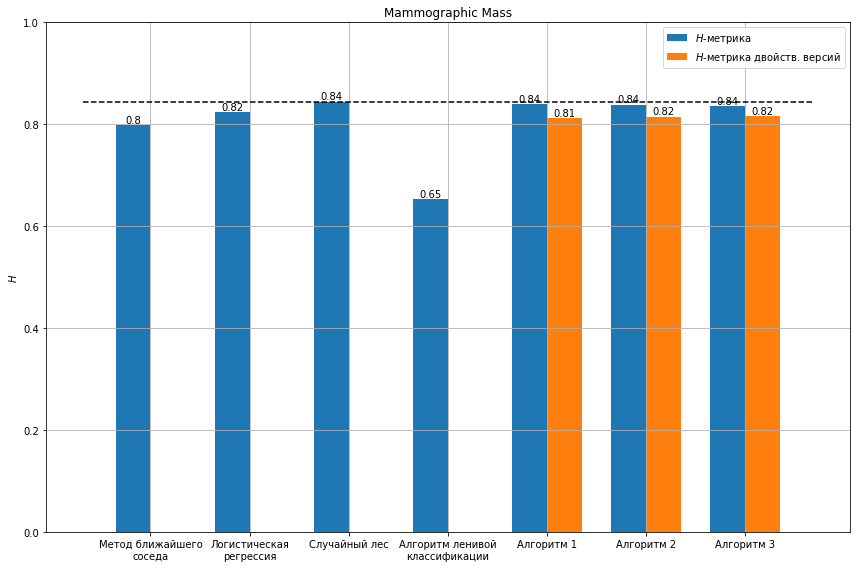

<Figure size 432x288 with 0 Axes>

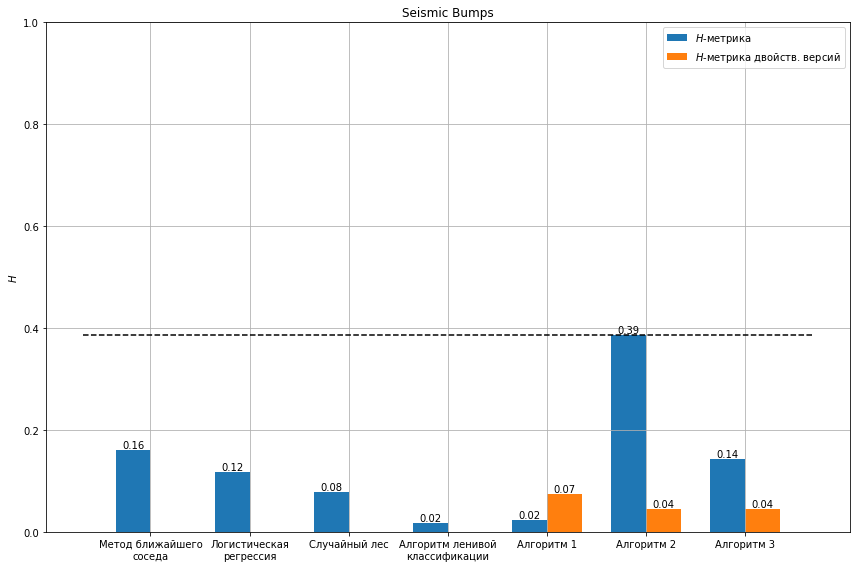

<Figure size 432x288 with 0 Axes>

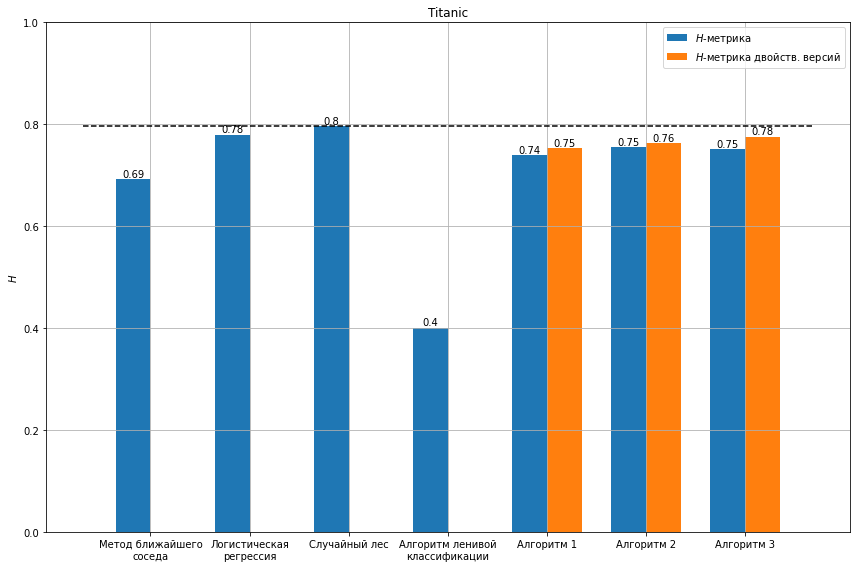

<Figure size 432x288 with 0 Axes>

In [8]:
x = np.arange(len(labels))
width = 0.35

for dataset in datasets:
    h_values = [get_h_values(frame[dataset]) for frame in frames.values()]
    h_values, h_values_dual = zip(*h_values)
    
    plt.figure(figsize=(12,8))
    rects1 = plt.bar(x - width/2, h_values, width, label='$H$-метрика')
    rects2 = plt.bar(x + width/2, h_values_dual, width, label='$H$-метрика двойств. версий')

    for i, (h1, h2) in enumerate(zip(h_values, h_values_dual)):
        plt.text(i-width/2, h1, str(h1.round(2)), va='bottom', ha='center')
        if h2 != 0:
            plt.text(i+width/2, h2, str(h2.round(2)), va='bottom', ha='center')
    
    plt.ylabel('$H$')
    plt.ylim(0, 1)
    plt.title(dataset)
    plt.xticks(x, labels)
    plt.legend()
    plt.grid()
    plt.hlines(max(max(h_values), max(h_values_dual)), *plt.xlim(), 'k', linestyles='--')

    plt.gcf().tight_layout()
    plt.savefig(dataset + '.pdf')
    plt.show()
    plt.clf()